# 1. Классификатор наивный Байес 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
n_samples = 5000

age_raw = np.random.randint(18, 71, size=n_samples)
income_raw = np.random.uniform(20, 200, size=n_samples)
visits_raw = np.clip(np.random.poisson(lam=5, size=n_samples), 0, 30)
duration_raw = np.clip(np.random.exponential(scale=5.0, size=n_samples), 0.5, 60.0)

age_group = pd.cut(
    age_raw,
    bins=[17, 25, 35, 50, 70],
    labels=['young', 'adult', 'middle', 'senior'],
    include_lowest=True
)

income_level = pd.cut(
    income_raw,
    bins=[0, 50, 100, 200],
    labels=['low', 'medium', 'high'],
    include_lowest=True
)

visits_cat = pd.cut(
    visits_raw,
    bins=[-1, 0, 5, 15, 30],
    labels=['none', 'rare', 'moderate', 'frequent'],
    include_lowest=True
)

duration_cat = pd.cut(
    duration_raw,
    bins=[0, 5, 15, 60],
    labels=['short', 'medium', 'long'],
    include_lowest=True
)

device_type = np.random.choice(['mobile', 'desktop', 'tablet'], size=n_samples, p=[0.6, 0.3, 0.1])
region = np.random.choice(['north', 'south', 'central', 'east'], size=n_samples, p=[0.25, 0.25, 0.3, 0.2])
newsletter_subscribed = np.random.choice([-1, 1], size=n_samples, p=[0.4, 0.6])

logit_p = (
    -2.0
    + 0.02 * (age_raw - 35)
    + 0.01 * (income_raw - 100)
    + 0.15 * visits_raw
    + 0.5 * newsletter_subscribed.astype(int)
    + 0.05 * duration_raw
    + (device_type == 'desktop') * 0.4
    + (region == 'central') * 0.3
)
purchased_prob = 1 / (1 + np.exp(-logit_p))
purchased = np.random.binomial(1, purchased_prob).astype(bool)

base_spend = np.zeros(n_samples)

bought = purchased  

spend_score = (
    0.3 * (income_raw / 200) +         
    0.2 * (visits_raw / 30) +           
    0.2 * (duration_raw / 60) +         
    0.15 * (device_type == 'desktop') + 
    0.15 * newsletter_subscribed        
)


base_spend[bought] = np.random.gamma(
    shape=1.5 + 2.0 * spend_score[bought], 
    scale=3.0,
    size=bought.sum()
)

base_spend[~bought] = 0.0

total_spend = base_spend

product_category = np.full(n_samples, 'none', dtype=object)
for i in range(n_samples):
    if purchased[i]:
        if device_type[i] == 'mobile' and age_raw[i] < 35:
            cat = np.random.choice(['phone', 'accessory'], p=[0.7, 0.3])
        elif device_type[i] == 'desktop' and income_raw[i] > 100:
            cat = np.random.choice(['laptop', 'phone'], p=[0.6, 0.4])
        else:
            cat = np.random.choice(['phone', 'laptop', 'accessory'], p=[0.5, 0.3, 0.2])
        product_category[i] = cat

categorial_dataset = pd.DataFrame({
    'age_group': age_group.astype(str),
    'income_level': income_level.astype(str),
    'visits_cat': visits_cat.astype(str),
    'duration_cat': duration_cat.astype(str),
    'device_type': device_type,
    'region': region,
    'newsletter_subscribed': newsletter_subscribed,
    'purchased': purchased,
    'product_category': product_category
})

real_dataset = pd.DataFrame({
    'age': age_raw.astype(float),
    'income': income_raw.astype(float),
    'visits': visits_raw.astype(float),
    'duration': duration_raw.astype(float),
    'device_type': device_type,
    'region': region,
    'newsletter_subscribed': newsletter_subscribed,
    'purchased': purchased,
    'product_category': product_category,
    'total_spend': total_spend
})
real_dataset.to_csv('real_dataset.csv', index=False)
categorial_dataset.to_csv('categorial_dataset.csv', index=False)

print("Категориальный датасет")
print("\nПример данных:")
print(categorial_dataset.head())
print("\nТипы данных:")
print(categorial_dataset.dtypes)
print("\nРаспределение метки 'purchased':")
print(categorial_dataset['purchased'].value_counts(normalize=True))

print("Датасет")
print("\nПример данных:")
print(real_dataset.head())
print("\nТипы данных:")
print(real_dataset.dtypes)
print("\nРаспределение метки 'purchased':")
print(real_dataset['purchased'].value_counts(normalize=True))

Категориальный датасет

Пример данных:
  age_group income_level visits_cat duration_cat device_type   region  \
0    senior       medium   moderate        short     desktop  central   
1    senior       medium       rare        short     desktop    north   
2    middle         high       rare        short     desktop    north   
3     adult          low       rare        short      tablet    north   
4    senior         high       rare        short     desktop    south   

   newsletter_subscribed  purchased product_category  
0                      1      False             none  
1                     -1      False             none  
2                      1       True            phone  
3                      1      False             none  
4                      1       True           laptop  

Типы данных:
age_group                object
income_level             object
visits_cat               object
duration_cat             object
device_type              object
region            

С помощью наивного Байеса можно предугадывать купит ли посетитель сайта какой-то товар  зависимости от возраста, кол-ва посещений и тд

In [2]:
class NaiveBaes:
    def __init__(self, dataset: pd.DataFrame):
        self.dataset = dataset
    
    def solve(self, x: dict, y: dict) -> float:
        return self.get_prob_xi(x, y) * self.get_choose_prob(list(y.keys()), list(y.values())) / self.get_choose_prob(list(x.keys()), list(x.values()))
    
    def predict(self, x: dict, y_label) -> str:
        predicts = {}
        for value in self.dataset[y_label].unique():
            predicts[value] = self.solve(x, {y_label : value})
            
        print(predicts)
    
    def get_prob_xi(self, x: dict, y: dict) -> float:
        prob = 1.0
        y_label, y_value = next(iter(y.items()))
        for x_label, x_value in x.items():
            if x_label in self.dataset.columns:
                cond_p = self.get_choose_prob_cond(x_value, x_label, y_value, y_label)
                prob *= cond_p
        return prob
            
    def get_choose_prob_cond(self, x: any, x_label: str, y: any, y_label: str) -> float:
        numerator = ((self.dataset[x_label] == x) & (self.dataset[y_label] == y)).sum()
        denominator = (self.dataset[y_label] == y).sum()
        return numerator / denominator if denominator != 0 else 0.0
    
    def get_choose_prob(self, labels, values):
        mask = pd.Series([True] * len(self.dataset), index=self.dataset.index)
        for label, value in zip(labels, values):
            mask &= (self.dataset[label] == value)
        
        return mask.mean()
                
    
model = NaiveBaes(categorial_dataset)
x = {'age_group': 'middle', 'device_type': 'desktop', 'visits_cat': 'moderate'} 
y = {'purchased': True}  
predict = model.predict(x, 'purchased')
    

{np.False_: np.float64(0.4260887336504161), np.True_: np.float64(0.57339084724799)}


# 2. Линейная регрессия

[150]
предсказание параметра ['total_spend'] по параметрам ['income']
[[0.73800623]
 [0.0188488 ]]
[[  1. 150.]]


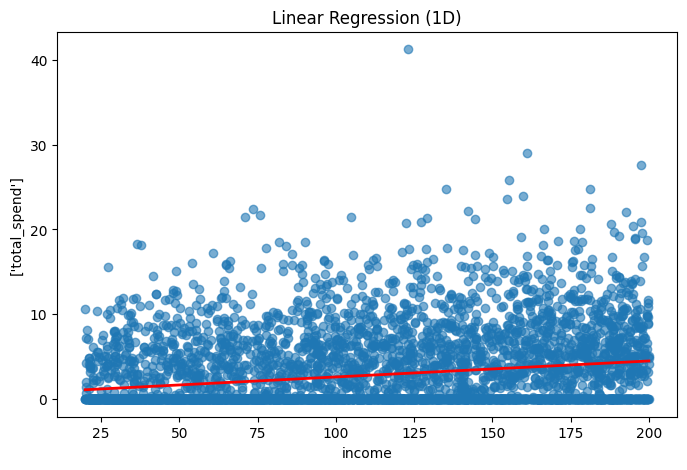

In [3]:
class LinearRegressionModel:
    def __init__(self, dataset: pd.DataFrame):
        self.dataset = dataset
        self.weights = np.array([])
        self.X = np.array([])
        self.Y = np.array([])
        self.X_with_bias = np.array([])
        self.lambda_p = 0.1
        
    def fit(self, x_label: list, y_label: list):
        self.X = self.dataset[x_label].to_numpy()
        self.X_with_bias = np.column_stack([np.ones(self.X.shape[0]), self.X])
        self.Y = self.dataset[y_label].to_numpy()
        determ = np.linalg.det(self.X.T @ self.X)
        if np.abs(determ) < 0.1:
            print("матрица почти вырождена, нужно применить регуляризацию L2")
            self.L2_regularize()
        else:
            self.weights = np.linalg.inv(self.X_with_bias.T @ self.X_with_bias) @ self.X_with_bias.T @ self.Y
            
    def L2_regularize(self):
        d_plus_1 = self.X_with_bias.shape[1]
        reg_matrix = np.eye(d_plus_1)
        reg_matrix[0, 0] = 0
        self.weights = np.linalg.inv(self.X_with_bias.T @ self.X_with_bias + self.lambda_p * reg_matrix) @ self.X_with_bias.T @ self.Y
    
    def predict(self, x: np.array, x_label: list, y_label: list):
        print(f'предсказание параметра {str(y_label)} по параметрам {str(x_label)}')  
        x_with_bias = np.column_stack([np.ones(x.shape[0]), x])
        print(self.weights)
        print(x_with_bias)
        prediction = x_with_bias @ self.weights
        return prediction
    
    def plot_result(self, x_label: list, y_label: list):
        if len(x_label) == 1:
            
            plt.figure(figsize=(8, 5))
            plt.scatter(self.X, self.Y, alpha=0.6)
            
            x_edge = np.array([self.X.min(), self.X.max()])
            y_pred = self.weights[0] + self.weights[1] * x_edge
            plt.plot(x_edge, y_pred, 'r-', linewidth=2)
            plt.xlabel(x_label[0])
            plt.ylabel(y_label)
            plt.title('Linear Regression (1D)')
            plt.show()
            
        elif len(x_label) == 2:
            
            x1 = self.X[:, 0]
            x2 = self.X[:, 1]
            
            fig = plt.figure(figsize=(10, 7))
            ax = fig.add_subplot(111, projection='3d')
            n_show = min(50, len(self.Y))
            if len(self.Y) > n_show:
                idx = np.random.choice(len(self.Y), n_show, replace=False)
                ax.scatter(x1[idx], x2[idx], self.Y[idx], alpha=0.6, label='Данные (выборка)')
            else:
                ax.scatter(x1, x2, self.Y, alpha=0.6, label='Данные')
            
            x1_min, x1_max = x1.min(), x1.max()
            x2_min, x2_max = x2.min(), x2.max()
            
            x1_grid = np.array([x1_min, x1_max])
            x2_grid = np.array([x2_min, x2_max])
            X1, X2 = np.meshgrid(x1_grid, x2_grid)
            
            Y_pred = (self.weights[0] 
                    + self.weights[1] * X1 
                    + self.weights[2] * X2)
            
            ax.plot_surface(X1, X2, Y_pred, alpha=0.3, color='red', rstride=1, cstride=1)
            ax.set_xlabel(x_label[0])
            ax.set_ylabel(x_label[1])
            ax.set_zlabel(y_label)
            ax.set_title('Linear Regression (2D features → 3D plot)')
            plt.show()
        else:
            print("Визуализация поддерживается только для 1 или 2 признаков.")
    
x_label = ['income']
y_label = ['total_spend']
x = np.array([150])
print(x)
I = np.ones([5, 5])
model = LinearRegressionModel(real_dataset)
model.fit(x_label, y_label)
model.predict(x, x_label, y_label)
model.plot_result(x_label, y_label)

# 3. Логистическая регрессия

In [4]:
class LogisticRegressionModel:
    def __init__(self, dataset: pd.DataFrame, norm_indices: list):
        self.dataset = dataset
        self.X = np.array([])
        self.X_with_bias = np.array([])
        self.Y = np.array([])
        self.weights = np.array([])
        self.loss = 0
        self.threshold = 0.1
        self.learning_rate = 3e-6
        self.sigmoids = np.array([])
        self.epoch = 0
        self.std = [0] * len(norm_indices)
        self.mean = [0] * len (norm_indices)
        self.norm_indices = norm_indices
        
    
    def fit(self, x_label: list, y_label: list):
        self.X = self.dataset[x_label].to_numpy()
        self.X = self.normalize(self.X)
        self.X_with_bias = np.column_stack([np.ones(self.X.shape[0]), self.X])
        self.Y = self.dataset[y_label].to_numpy() * 2 - 1
        self.weights = np.random.randn(self.X_with_bias.shape[1]) 
        self.weights = self.weights.reshape(-1, 1)
        #print(self.weights)

        self.logistic_loss()
        while np.abs(self.loss) > self.threshold and self.epoch < 3000:
            self.iteration()
            
    def normalize(self, data: np.array, learn: bool = True) -> np.array:
        for i in range(len(self.norm_indices)):
            col = data[:, self.norm_indices[i]]
            if learn:
                self.std[i] = np.std(col)
                self.mean[i] = np.mean(col)
            data[:, self.norm_indices[i]] = (col - self.mean[i]) / (self.std[i] + 1e-8)
        return data
        
    def predict(self, x: np.array):
        x = self.normalize(x, False)
        x_with_bias = np.column_stack([np.ones(x.shape[0]), x])
        return 1 / (1 + np.exp(- x_with_bias @ self.weights))
        
    def iteration(self):
        gradient = self.logistic_loss_gradient()
        #print(gradient)
        self.weights -= self.learning_rate * gradient
        #print(self.weights)
        self.logistic_loss()
        
        self.epoch +=1
        if self.epoch % 100 == 0:
            print(f'epoch {self.epoch}, loss = {self.loss}')
    
    def logistic_loss(self):
        self.sigmoids = np.array([self.sidmoid(index) for index in range(self.Y.shape[0])])
        self.loss = np.mean(-np.log(self.sigmoids))
    
    def logistic_loss_gradient(self):
        elements = np.array([-self.Y[index, :] * self.X_with_bias[index, :] * (1 - self.sigmoids[index]) for index in range(self.sigmoids.shape[0])])
        return np.sum(elements, axis=0).reshape(-1, 1)
    
    def sidmoid(self, index):
        return 1 / (1 + np.exp(-self.margin(index)))
    
    def margin(self, index):
        return self.Y[index, :] * self.X_with_bias[index, :] @ self.weights 
    
    
x = np.array([[45, 30, 1, 0.2, -1]])

print(x.shape)
x_label = ['age', 'income', 'visits', 'duration', 'newsletter_subscribed'] 
y_label = ['purchased'] 
model = LogisticRegressionModel(real_dataset, [0, 1, 2, 3])
model.fit(x_label, y_label)

print(model.predict(x))

(1, 5)
epoch 100, loss = 0.7444863521704285
epoch 200, loss = 0.6741032258698199
epoch 300, loss = 0.6393159629270939
epoch 400, loss = 0.622825053640399
epoch 500, loss = 0.6150082486484876
epoch 600, loss = 0.6112297626414008
epoch 700, loss = 0.6093531089730649
epoch 800, loss = 0.6083933132424122
epoch 900, loss = 0.6078878570813069
epoch 1000, loss = 0.6076140513701686
epoch 1100, loss = 0.6074617301469062
epoch 1200, loss = 0.6073748771629152
epoch 1300, loss = 0.6073242296410173
epoch 1400, loss = 0.6072940949562056
epoch 1500, loss = 0.6072758440045339
epoch 1600, loss = 0.6072646181183474
epoch 1700, loss = 0.6072576206688333
epoch 1800, loss = 0.6072532090991707
epoch 1900, loss = 0.607250400927143
epoch 2000, loss = 0.607248598866769
epoch 2100, loss = 0.607247434582156
epoch 2200, loss = 0.6072466780864888
epoch 2300, loss = 0.6072461842311854
epoch 2400, loss = 0.6072458605679659
epoch 2500, loss = 0.6072456477548601
epoch 2600, loss = 0.6072455074495697
epoch 2700, loss =

# 4. Метод опорных векторов

           x1        x2  y
0    0.127071  1.013042  1
1    2.312935  3.770534  1
2    3.340428  3.420996  1
3    3.294548  0.595620  1
4    1.944105  1.477241  1
..        ...       ... ..
195 -3.325239  0.080488 -1
196 -1.741314  2.970952 -1
197 -1.581615  2.196672 -1
198  1.871664  2.690409  1
199 -0.062896  4.525581 -1

[200 rows x 3 columns]


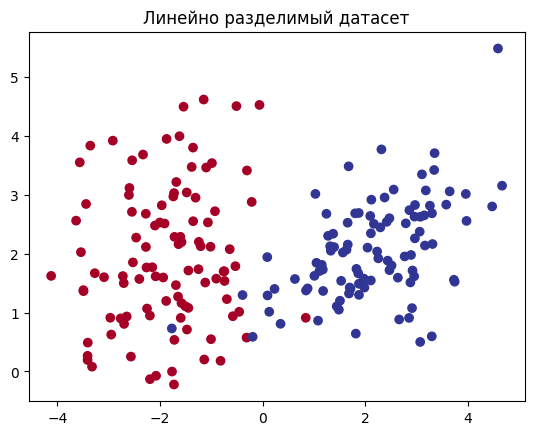

In [5]:
from sklearn.datasets import make_classification


X_linear, y_linear = make_classification(
    n_samples=200,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    class_sep=2.0,  # Большое расстояние между классами
    random_state=42
)
y_linear = y_linear * 2 - 1
svm_dataset1 = pd.DataFrame({
    "x1" : X_linear[:, 0],
    "x2" : X_linear[:, 1],
    "y" : y_linear
})

print(svm_dataset1)
plt.scatter(X_linear[:, 0], X_linear[:, 1], c=y_linear, cmap='RdYlBu')
plt.title('Линейно разделимый датасет')
plt.show()

epoch 0, loss = 288.7852150911986
epoch 100, loss = 13.678553100755666, accuracy = 0.98
epoch 200, loss = 13.537119304333466, accuracy = 0.985
epoch 300, loss = 13.524868340542342, accuracy = 0.98
epoch 400, loss = 13.512622035926483, accuracy = 0.98
epoch 500, loss = 13.500400311603327, accuracy = 0.98
epoch 600, loss = 13.488203124729655, accuracy = 0.98
epoch 700, loss = 13.47776300026882, accuracy = 0.98
epoch 800, loss = 13.463569245291152, accuracy = 0.98
epoch 900, loss = 13.451445329594277, accuracy = 0.98
epoch 1000, loss = 13.43934575257977, accuracy = 0.98
epoch 1100, loss = 13.427270465834873, accuracy = 0.98
epoch 1200, loss = 13.415219423769166, accuracy = 0.98
epoch 1300, loss = 13.404801444945473, accuracy = 0.98
epoch 1400, loss = 13.3965906738475, accuracy = 0.98
epoch 1500, loss = 13.3880429199925, accuracy = 0.98
epoch 1600, loss = 13.38377054059743, accuracy = 0.98
epoch 1700, loss = 13.380366836057792, accuracy = 0.98
epoch 1800, loss = 13.381285046440128, accurac

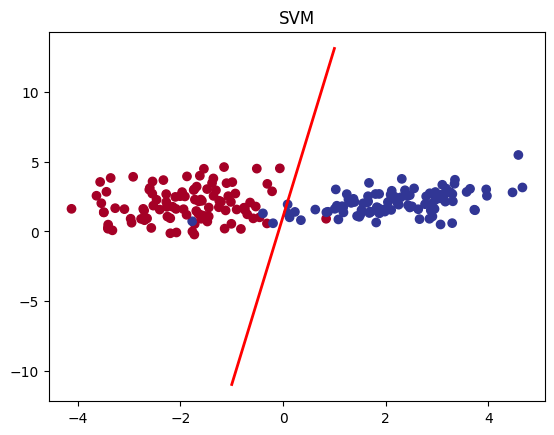

In [6]:
class SVMMethod:
    def __init__(self, dataset: pd.DataFrame, c_hyper: float):
        self.dataset = dataset
        self.c_hyper = c_hyper
        self.X = np.array([])
        self.Y = np.array([])
        self.X_with_bias = np.array([])
        self.weights = np.array([])
        self.loss = 0
        self.threshold = 0.1
        self.learning_rate = 1e-2
        self.epoch = 0
        self.std = []
        self.mean = []
    
    def fit(self, x_label: list, y_label: list):
        self.X = self.dataset[x_label].to_numpy()
        self.X = self.normalize(self.X)
        self.Y = self.dataset[y_label].to_numpy()
        self.X_with_bias = np.column_stack([-1 * np.ones(self.X.shape[0]), self.X])
        self.weights = np.random.randn(self.X_with_bias.shape[1]) 
        self.weights = self.weights.reshape(-1, 1)
        self.loss = self.hinge_loss()
        print(f'epoch {self.epoch}, loss = {self.loss}')
        while self.loss > self.threshold and self.epoch < 10000:
            self.iteration()
        
    def normalize(self, data: np.array, learn: bool = True):
        for i in range(data.shape[1]):
            col = data[:, i]
            if learn:
                self.std.append(np.std(col))
                self.mean.append(np.mean(col))
            data[:, i] = (col - self.mean[i]) / (self.std[i] + 1e-8)
        return data
    
    def iteration(self):
        gradient = self.hinge_loss_gradient()
        self.weights -= self.learning_rate * gradient
        
        self.loss = self.hinge_loss()
        
        self.epoch += 1
        if self.epoch % 100 == 0:
            print(f'epoch {self.epoch}, loss = {self.loss}, accuracy = {self.count_accuracy()}')
    
    def predict(self, x: np.array):
        x = self.normalize(x, False)
        x = np.column_stack([-1 * np.ones(x.shape[0]), x])
        return np.sign(x @ self.weights)
    
    def count_accuracy(self):
        predictions = [np.sign(self.X_with_bias[index, :] @ self.weights) for index in range(self.Y.shape[0])]
        count = 0
        for i in range(len(predictions)):
            if predictions[i] == self.Y[i, 0]:
                count += 1
                
        return count / self.Y.shape[0]        
    
    def hinge_loss(self):
        return np.sum([max(0, 1 - self.margin(index)[0]) for index in range(self.Y.shape[0])]) + (np.linalg.norm(self.weights) ** 2) / (2 * self.c_hyper)
    
    def hinge_loss_gradient(self):
        n = self.Y.shape[0]
        grad = np.zeros_like(self.weights)
        
        for i in range(n):
            margin_val = self.margin(i)[0] 
            if margin_val < 1:
                grad -= self.Y[i, 0] * self.X_with_bias[i, :].reshape(-1, 1)
        
        grad += self.weights / self.c_hyper
        return grad
    
    def margin(self, index):
        return self.Y[index, 0] * self.X_with_bias[index, :] @ self.weights 
    
    def plot(self):
        plt.scatter(X_linear[:, 0], X_linear[:, 1], c=y_linear, cmap='RdYlBu')
        plt.title('SVM')
        x1_min, x1_max = -1, 1
        w0, w1, w2 = self.weights.flatten()
        print(w0, w1, w2)
        # w1 * x1 + w2 * x2 - w0 = 0
        # x2 = (w0 - w1 * x1) / w2
        x2_min = (w0 - w1 * x1_min) / w2
        x2_max = (w0 - w1 * x1_max) / w2
        plt.plot([x1_min, x1_max], [x2_min, x2_max], 'r-', linewidth=2)
        plt.show()
    
    
x_label = ["x1", "x2"]
y_label = ["y"]
x = np.array([[3, 3]])
model = SVMMethod(svm_dataset1, 1000)
model.fit(x_label, y_label)
model.predict(x)
model.plot()

# 5. Решающие деревья

In [ ]:
class SolvingTreeNode:
    def __init__(self):
        self.feature_index = None
        self.threshold = None
        self.child_left = None
        self.child_right = None
        self.prediction = None 

class SolvingTreeModel:
    def __init__(self, dataset: pd.DataFrame, max_depth = 5, min_samples = 20, use_loss = 0):
        self.dataset = dataset
        self.root = None
        if use_loss == 0:
            self.loss = self.entropy_loss
        else:
            self.loss = self.gini_impurity_loss
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.num_classes = len(np.unique(y))
        
    def fit(self, x_label: list, y_label: str):
        x = self.dataset[x_label].to_numpy()
        y = self.dataset[y_label].to_numpy()
        self.root = self.grow_tree(self.X, self.Y, 0)
        
        
    def best_split(self, x: np.array, y: np.array):
        
    
    def grow_tree(self, x : np.array, y: np.array, depth) -> SolvingTreeNode:
        new_node = SolvingTreeNode()
        num_samples = len(y)
        num_classes = len(np.unique(y))
        if self.check_finish(depth, num_samples, num_classes):
            values, counts = np.unique(y, return_counts=True)
            new_node.prediction = values[np.argmax(counts)]
            return new_node
        
        threshold, feature_index = self.best_split(x, y)
        if feature_index == None:
            values, counts = np.unique(y, return_counts=True)
            new_node.prediction = values[np.argmax(counts)]
            return new_node
            
        new_node.feature_index = feature_index
        new_node.threshold = threshold
        
        left_data = x[:, feature_index] <= threshold
        right_data = ~left_data
        
        new_node.child_left = self.grow_tree(x[left_data], y[left_data])
        new_node.child_right = self.grow_tree(x[right_data], y[right_data])
        
        return new_node 
        
        
    def check_finish(self, depth, num_samples, num_classes) -> bool:
        return (depth > self.max_depth and num_samples <= self.min_samples and num_classes == 1)
    
    def sample_probability(self, data: np.array, value):
        return (np.count_nonzero(data == 2)) / len(data)  
    
    def entropy_loss(self):
        pass
    
    def gini_impurity_loss(self):
        pass


In [8]:
class RandomForestModel:
    def __init__(self):
        pass

In [9]:
class IsolationForestModel:
    def __init__(self):
        pass